# Running regression on the dataframe we developed from our SQL db

Reference material for the meaning of each column can be found here: https://labrosa.ee.columbia.edu/millionsong/pages/field-list   
Mode: 1 = minor, 0 = major (after checking manually)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>")) #reduce margins in jupyter notebook

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
!ls # what did I call those csv files?

README.md                       historical_top_100.csv
amazon_ec2_notes.ipynb          images
create_track_metadata_db_new.py million_songs.csv
data_cleaning.ipynb             regression_on_df.ipynb
final_ranked_song_db.csv        scrape_top_100.ipynb
find_superlatives_eda.ipynb     subset_extraction.ipynb
full_extraction.ipynb           top_single_prediction.key


In [4]:
million_songs = pd.DataFrame.from_csv('/Users/horisustar/projects/project2backup/final_ranked_song_db.csv',sep=',') #import csv

/Users/horisustar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [5]:
million_songs.head()

,artist_name,rating,title,year,release,duration,artist_familiarity,artist_hotttnesss,key,loudness,mode,song_hotttnesss,tempo,time_signature
0,Mark Dinning,5,Teen Angel,1960,True Rock N Roll 3CD Set,158.95465,0.469933,0.334437,0,-12.697,1,-1.000000,100.699,4
1,Jimmy Jones,8,Handy Man,1960,The Greatest Rock 'n' Roll Hits,123.89832,0.550149,0.346467,10,-12.036,1,-1.000000,143.655,4
2,Chubby Checker,10,The Twist,1960,Hits of The 60's Volume 1,164.36200,0.631271,0.439454,11,-9.814,0,-1.000000,154.208,7
3,Chubby Checker,9,The Twist,1962,Hits of The 60's Volume 1,164.36200,0.631271,0.439454,11,-9.814,0,-1.000000,154.208,7
4,Bobby Rydell,12,Wild One,1960,The Ultimate Sixties Collection,136.88118,0.504600,0.368641,7,-8.317,1,0.731105,151.581,3


In [6]:
million_songs.columns

Index(['artist_name', 'rating', 'title', 'year', 'release', 'duration',
       'artist_familiarity', 'artist_hotttnesss', 'key', 'loudness', 'mode',
       'song_hotttnesss', 'tempo', 'time_signature'],
      dtype='object')

In [7]:
drop_list = ['artist_name', 'title','release'] #get rid of cols we don't need for regression
data = million_songs.drop(drop_list,axis=1)

In [15]:
keys = pd.get_dummies(data['key'], prefix='key', drop_first=True) # create our dummy columns and put them in their own db
modes = pd.get_dummies(data['mode'], prefix='mode', drop_first=True)
time_signatures = pd.get_dummies(data['time_signature'], prefix='time_signature', drop_first=True)
ratings = pd.get_dummies(data['rating'], prefix='rating', drop_first=True)

In [16]:
reg_data = data.drop(['key','time_signature','mode','rating'], axis=1)

In [17]:
reg_data.head()

,year,duration,artist_familiarity,artist_hotttnesss,loudness,song_hotttnesss,tempo
0,1960,158.95465,0.469933,0.334437,-12.697,-1.000000,100.699
1,1960,123.89832,0.550149,0.346467,-12.036,-1.000000,143.655
2,1960,164.36200,0.631271,0.439454,-9.814,-1.000000,154.208
3,1962,164.36200,0.631271,0.439454,-9.814,-1.000000,154.208
4,1960,136.88118,0.504600,0.368641,-8.317,0.731105,151.581


In [18]:
reg_data = pd.concat([data,key,modes,time_signatures], axis = 1) # add ratings back in potentially #append dbs with 
                                            # keys(not relevant on further inspection) modes, time_signatures, ratings
reg_data.head()

NameError: name 'key' is not defined

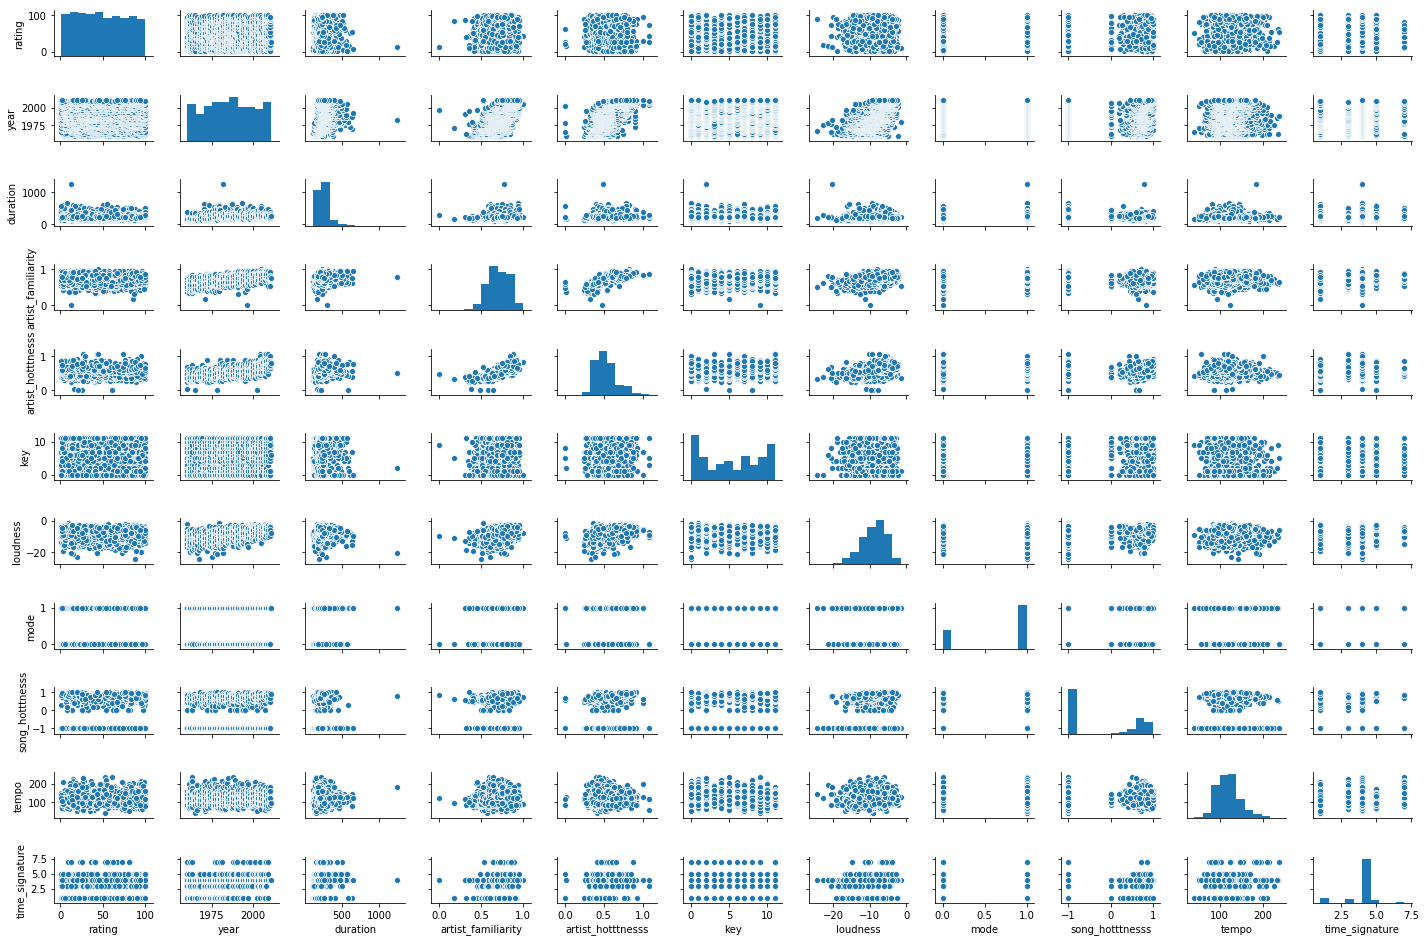

In [11]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(data, height=1.2, aspect=1.5)

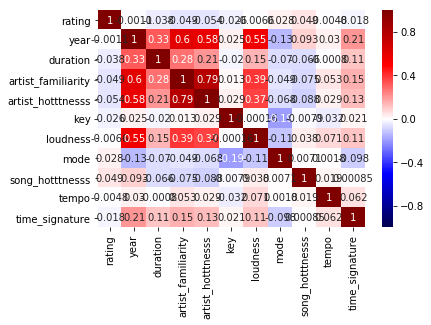

In [12]:
sns.heatmap(data.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [19]:
reg_data.columns

Index(['year', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'loudness', 'song_hotttnesss', 'tempo'],
      dtype='object')

In [21]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('rating ~ year + artist_familiarity**2 + artist_hotttnesss \
       + loudness + mode + song_hotttnesss + tempo + key_1 + key_2 + key_3 + key_4 \
       + key_5 + key_6 + key_7 + key_8 + key_9 + key_10 + key_11 + mode_1 + time_signature_3 \
       + time_signature_4 + time_signature_5 + time_signature_7', data=reg_data, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

PatsyError: Error evaluating factor: NameError: name 'time_signature_5' is not defined
    rating ~ year + artist_familiarity**2 + artist_hotttnesss        + loudness + mode + song_hotttnesss + tempo + key_1 + key_2 + key_3 + key_4        + key_5 + key_6 + key_7 + key_8 + key_9 + key_10 + key_11 + mode_1 + time_signature_3        + time_signature_4 + time_signature_5 + time_signature_7
                                                                                                                                                                                                                                                                          ^^^^^^^^^^^^^^^^

In [27]:
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = reg_data.iloc[:, 1:]

# Choose the response variable(s)
y = reg_data.iloc[:, 0]

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.019119517764612515